In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_columns', 50)

### №1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [2]:
covid_df = pd.read_csv('data/owid-covid-data.csv', dtype={}, parse_dates=[2], dayfirst=True)
covid_df.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [3]:
covid_df = covid_df[['location', 'date', 'total_cases', 'new_cases']]
covid_df.head()

,location,date,total_cases,new_cases
0,Aruba,2020-03-13,2,2
1,Aruba,2020-03-20,4,2
2,Aruba,2020-03-24,12,8
3,Aruba,2020-03-25,17,5
4,Aruba,2020-03-26,19,2


In [4]:
covid_df.new_cases.clip(lower=1, inplace=True)

In [5]:
russia = covid_df.query('location == "Russia"')
russia.head()

,location,date,total_cases,new_cases
13874,Russia,2019-12-31,0,1
13875,Russia,2020-01-01,0,1
13876,Russia,2020-01-02,0,1
13877,Russia,2020-01-03,0,1
13878,Russia,2020-01-04,0,1


In [6]:
split_date = datetime.strptime('2020-03-03', '%Y-%m-%d') + timedelta(days=50)
split_str = split_date.strftime('%Y-%m-%d')
split_date, split_str

(datetime.datetime(2020, 4, 22, 0, 0), '2020-04-22')

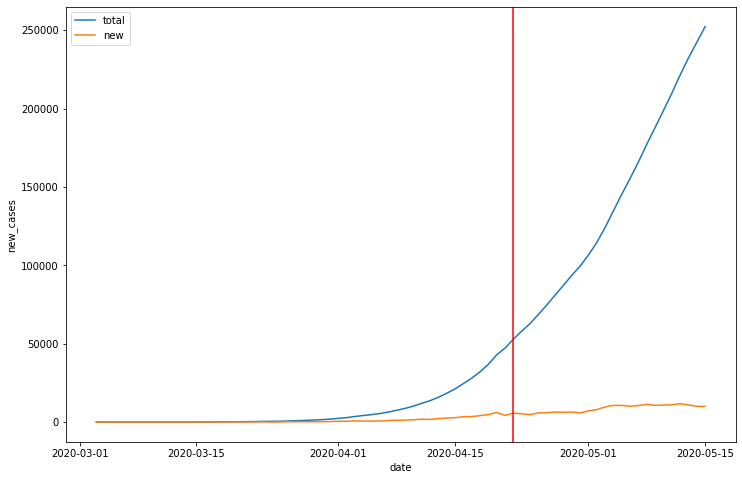

In [8]:
plt.figure(figsize=(12,8))
sns.lineplot(x='date', y='total_cases', data=russia.query('date >= "2020-03-03"'), label='total')
sns.lineplot(x='date', y='new_cases', data=russia.query('date >= "2020-03-03"'), label='new')
plt.axvline(x=split_date, color=(1,0,0))

In [9]:
train = russia.query(f'date >= "2020-03-03" and date <= "{split_str}"')
test = russia.query(f'date > "{split_str}"')
len(train), len(test)

(51, 23)

### №2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.  
    **a)** Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.  
    **b)** Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).  
    **c)** Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).  

Большая - дисперсия заведомо в разы больше, чем ожидаемые веса

### №3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана.


Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.  
    **a)** Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.  
    **b)** Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.  
    **c)** Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

### №4
Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

### №5
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?